# 📊 t-SNE & UMAP - 非线性降维可视化

> 超越PCA，探索高维数据的真实结构

---

## 📚 学习目标

完成本Notebook后，你将能够：

- ✅ 理解PCA的局限性和非线性降维的必要性
- ✅ 掌握t-SNE的原理、参数和应用场景
- ✅ 理解UMAP的优势和使用方法
- ✅ 对比PCA、t-SNE、UMAP的优劣势
- ✅ 学会选择合适的降维方法
- ✅ 掌握非线性降维的最佳实践

---

## 1. 为什么需要非线性降维？

### 1.1 PCA的局限性

PCA是一种**线性降维**方法，它假设数据的主要变化方向是线性的：

**PCA能做的：**
- ✅ 找到方差最大的线性方向
- ✅ 快速、高效、数学严谨
- ✅ 适合线性可分的数据

**PCA不能做的：**
- ❌ 无法处理流形结构（如瑞士卷、S曲线）
- ❌ 不能保持数据的局部邻域关系
- ❌ 对于复杂的非线性数据效果有限

### 1.2 非线性降维的优势

**t-SNE** 和 **UMAP** 是两种强大的非线性降维技术：

- ✅ 保持数据的局部结构
- ✅ 能够揭示复杂的数据分布
- ✅ 特别适合可视化高维数据
- ✅ 可以展开流形结构

### 1.3 快速对比

| 特性 | PCA | t-SNE | UMAP |
|------|-----|-------|------|
| **类型** | 线性 | 非线性 | 非线性 |
| **保持特性** | 全局方差 | 局部结构 | 全局+局部 |
| **速度** | 快 O(d³) | 慢 O(n²) | 快 O(n log n) |
| **确定性** | 确定 | 随机 | 随机 |
| **主要用途** | 降维+可视化 | 可视化 | 降维+可视化 |
| **降维后建模** | ✅ 推荐 | ❌ 不推荐 | ✅ 可以 |
| **大规模数据** | ✅ | ❌ | ✅ |

---

## 2. 环境准备

In [4]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time

# 降维算法
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 尝试导入UMAP（可选依赖）
try:
    import umap
    UMAP_AVAILABLE = True
    print("✅ UMAP已安装")
except ImportError:
    UMAP_AVAILABLE = False
    print("⚠️ UMAP未安装")
    print("   安装命令: pip install umap-learn")
    print("   注意: 本notebook在没有UMAP的情况下也可以运行")

# 数据集
from sklearn.datasets import (
    load_iris, load_digits,
    make_swiss_roll, make_s_curve,
    make_moons, make_circles
)
from sklearn.preprocessing import StandardScaler

# 评估
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
        'Arial Unicode MS',  # macOS通用
        'PingFang SC',       # macOS系统字体
        'STHeiti',           # 华文黑体
        'Heiti TC',          # 黑体-繁
        'SimHei',            # 黑体
    ]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置随机种子
np.random.seed(42)

print("\n✅ 环境准备完成！")

✅ UMAP已安装

✅ 环境准备完成！


## 3. 非线性数据示例：瑞士卷

瑞士卷（Swiss Roll）是经典的非线性流形数据，用于演示线性方法的局限性。

**什么是流形？**
- 流形是高维空间中的低维曲面
- 例如：3D空间中的2D卷曲纸张
- 数据沿着流形分布，但嵌入在高维空间中

数据形状: (1500, 3)
颜色变量（展开长度）: (1500,)

💡 瑞士卷是3D空间中的2D流形


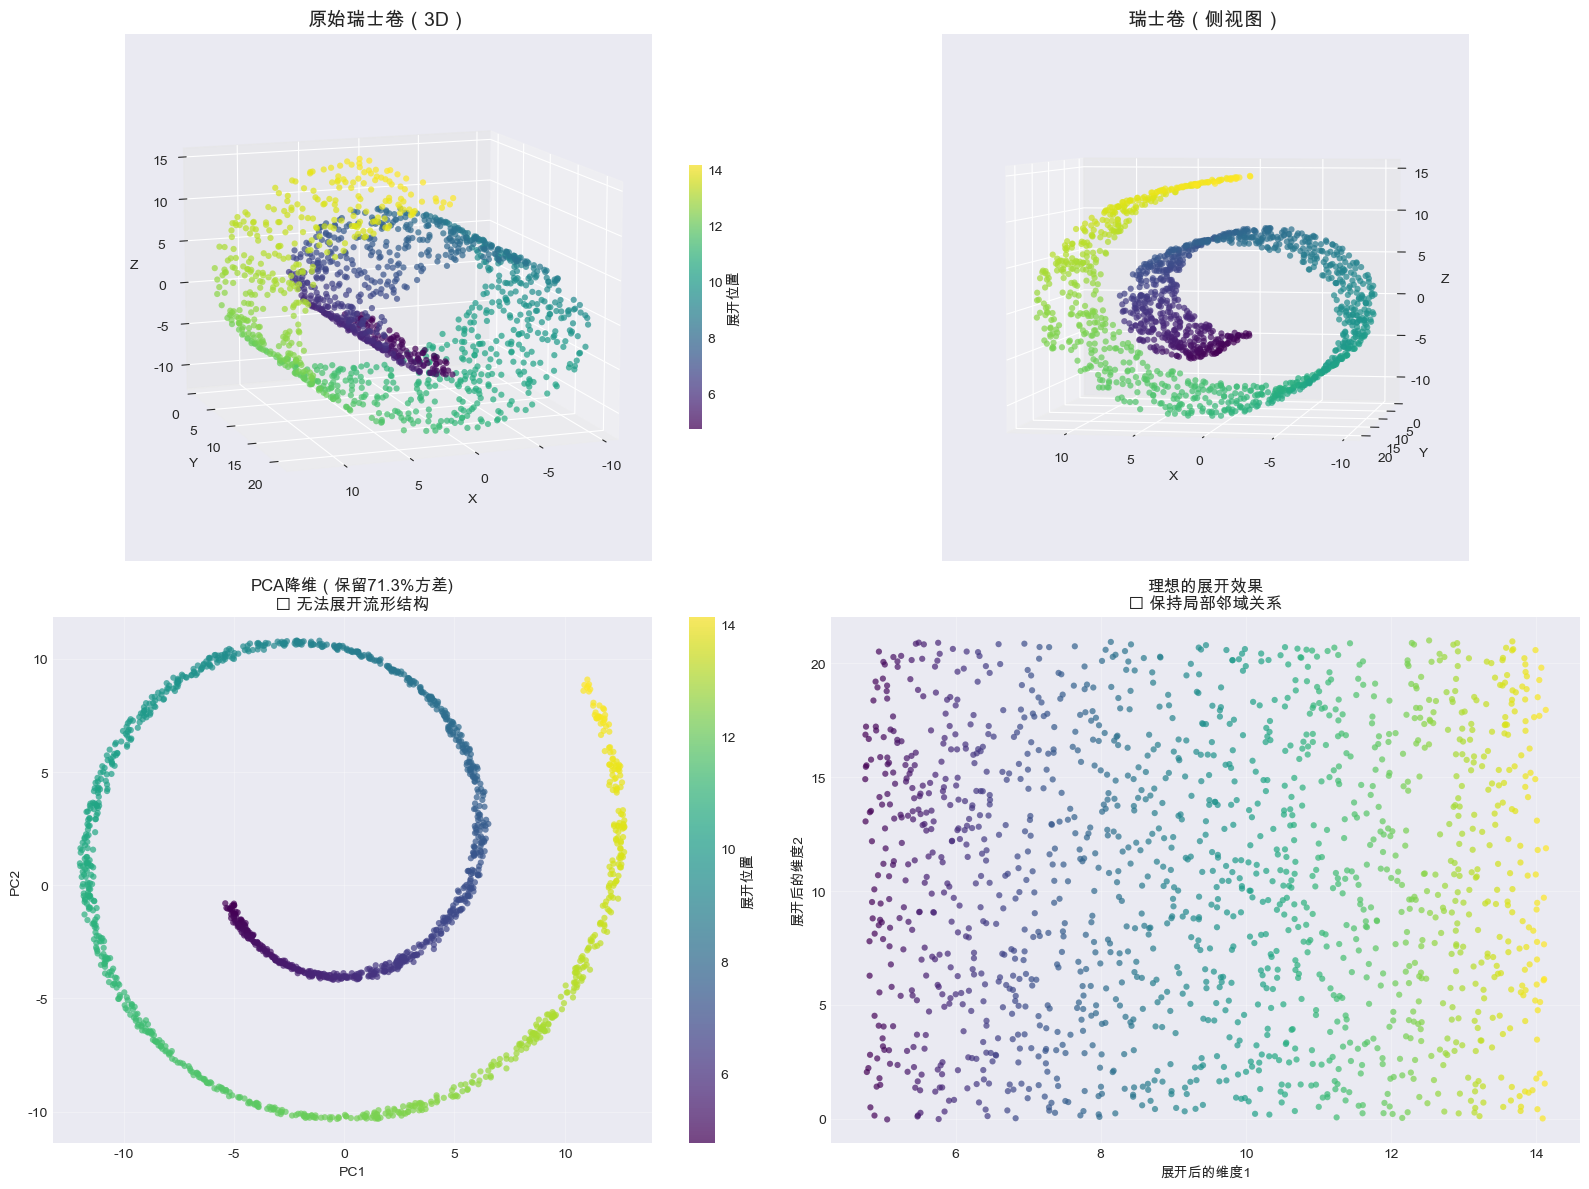


💡 观察:
  - 瑞士卷是3D空间中的2D流形
  - PCA作为线性方法，无法『展开』这个卷曲结构
  - 我们需要非线性方法来保持数据的内在几何结构


In [8]:
# 生成瑞士卷数据
n_samples = 1500
X_swiss, t_swiss = make_swiss_roll(n_samples=n_samples, noise=0.05, random_state=42)

print(f"数据形状: {X_swiss.shape}")
print(f"颜色变量（展开长度）: {t_swiss.shape}")
print(f"\n💡 瑞士卷是3D空间中的2D流形")

# 3D可视化原始瑞士卷
fig = plt.figure(figsize=(16, 12))

# 子图1：3D瑞士卷（角度1）
ax1 = fig.add_subplot(221, projection='3d')
scatter = ax1.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2],
                     c=t_swiss, cmap='viridis', s=20, alpha=0.7, edgecolors='none')
ax1.set_title('原始瑞士卷（3D）', fontsize=14, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
plt.colorbar(scatter, ax=ax1, shrink=0.5, label='展开位置')
ax1.view_init(elev=12, azim=70)

# 子图2：不同角度
ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2],
           c=t_swiss, cmap='viridis', s=20, alpha=0.7, edgecolors='none')
ax2.set_title('瑞士卷（侧视图）', fontsize=14, fontweight='bold')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.view_init(elev=4, azim=100)

# 应用PCA降维
pca_swiss = PCA(n_components=2)
X_swiss_pca = pca_swiss.fit_transform(X_swiss)

# 子图3：PCA结果
ax3 = fig.add_subplot(223)
scatter3 = ax3.scatter(X_swiss_pca[:, 0], X_swiss_pca[:, 1],
                      c=t_swiss, cmap='viridis', s=20, alpha=0.7, edgecolors='none')
ax3.set_title(f'PCA降维（保留{pca_swiss.explained_variance_ratio_.sum():.1%}方差)\n'
             '❌ 无法展开流形结构', fontsize=12, fontweight='bold')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=ax3, label='展开位置')

# 子图4：理想展开结果示意
ax4 = fig.add_subplot(224)
ax4.scatter(t_swiss, X_swiss[:, 1], c=t_swiss, cmap='viridis', s=20, alpha=0.7, edgecolors='none')
ax4.set_title('理想的展开效果\n✅ 保持局部邻域关系', fontsize=12, fontweight='bold')
ax4.set_xlabel('展开后的维度1')
ax4.set_ylabel('展开后的维度2')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 观察:")
print("  - 瑞士卷是3D空间中的2D流形")
print("  - PCA作为线性方法，无法『展开』这个卷曲结构")
print("  - 我们需要非线性方法来保持数据的内在几何结构")

## 4. t-SNE（t-分布随机邻域嵌入）

### 4.1 核心思想

**t-SNE** (t-Distributed Stochastic Neighbor Embedding) 的目标是：
- 在高维空间中，相似的点应该靠近
- 在低维空间中，也保持这种相似性
- 使用概率分布来衡量相似性

**核心直觉**：想象你有一张高维空间中点之间"亲密度"的地图，t-SNE 试图在低维空间中重建这张地图，让原本亲近的点在新空间中依然亲近。

---

### 4.2 算法流程详解

---

## 📐 步骤1：计算高维空间中的相似度（条件概率）

### 公式

$$p_{j|i} = \frac{\exp(-||x_i - x_j||^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-||x_i - x_k||^2 / 2\sigma_i^2)}$$

### 公式逐项解释

| 符号 | 含义 | 直观理解 |
|------|------|----------|
| $p_{j\|i}$ | 以点 $i$ 为中心时，点 $j$ 是其邻居的概率 | "从 $i$ 的视角看，$j$ 有多亲近？" |
| $x_i, x_j$ | 高维空间中的数据点 | 原始数据的第 $i$ 和第 $j$ 个样本 |
| $\|\|x_i - x_j\|\|^2$ | 欧氏距离的平方 | 两点在原始空间中的距离 |
| $\sigma_i$ | 以点 $i$ 为中心的高斯分布的标准差（带宽） | 控制"邻域"的大小，每个点可以不同 |
| $\exp(-d^2/2\sigma^2)$ | 高斯核函数 | 距离越近，值越大；距离越远，指数衰减 |
| 分母 $\sum_{k \neq i}$ | 归一化项 | 确保所有概率之和为1 |

### 为什么选择高斯分布？

1. **局部敏感性**：高斯分布在中心附近值大，远离中心快速衰减
2. **数学性质好**：可微，便于梯度计算
3. **自然解释**：概率随距离指数衰减，符合"相似性"的直觉

### σᵢ 如何确定？—— Perplexity（困惑度）的作用

**问题**：不同区域的数据密度不同，使用固定的 $\sigma$ 会导致：
- 在密集区域：邻域太大，包含太多点
- 在稀疏区域：邻域太小，几乎没有邻居

**解决方案**：为每个点 $i$ 自适应地选择 $\sigma_i$，使其"有效邻居数"等于用户指定的 perplexity。

**Perplexity 的定义**：

$$Perp(P_i) = 2^{H(P_i)}$$

其中 $H(P_i)$ 是以点 $i$ 为中心的条件分布的香农熵：

$$H(P_i) = -\sum_j p_{j|i} \log_2 p_{j|i}$$

**直观理解**：
- Perplexity ≈ 每个点的"有效邻居数量"
- 设置 perplexity=30 意味着每个点大约有30个有效邻居
- 算法通过二分搜索找到使 $Perp(P_i) = $ 目标值的 $\sigma_i$

### 对称化：从条件概率到联合概率

**问题**：$p_{j|i} \neq p_{i|j}$（非对称）

例如：在密集区域的点 $i$ 看稀疏区域的点 $j$，和反过来看，概率不同。

**解决方案**：对称化

$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}$$

| 符号 | 含义 |
|------|------|
| $p_{ij}$ | 点 $i$ 和点 $j$ 的联合相似度（对称） |
| $n$ | 样本总数 |
| 除以 $2n$ | 归一化，确保 $\sum_{i,j} p_{ij} = 1$ |

**对称化的好处**：
1. 保证 $p_{ij} = p_{ji}$
2. 简化后续的 KL 散度计算
3. 确保每个点对整体分布的贡献最小为 $\frac{1}{2n}$（避免离群点被完全忽略）

---

## 📐 步骤2：计算低维空间中的相似度（使用t分布）

### 公式

$$q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l} (1 + ||y_k - y_l||^2)^{-1}}$$

### 公式逐项解释

| 符号 | 含义 | 直观理解 |
|------|------|----------|
| $q_{ij}$ | 低维空间中点 $i$ 和点 $j$ 的相似度 | "在降维后的空间中，$i$ 和 $j$ 有多亲近？" |
| $y_i, y_j$ | 低维空间中的嵌入点 | 这是我们要学习/优化的目标 |
| $\|\|y_i - y_j\|\|^2$ | 低维空间中的欧氏距离平方 | 降维后两点的距离 |
| $(1 + d^2)^{-1}$ | **t分布核**（自由度=1的Student-t分布） | 也称为柯西分布 |
| 分母 $\sum_{k \neq l}$ | 归一化项 | 确保所有 $q_{ij}$ 之和为1 |

### 🔑 关键问题：为什么使用 t 分布而不是高斯分布？

#### 拥挤问题（Crowding Problem）

**问题描述**：
- 高维空间中，中等距离的点对数量远多于近距离点对
- 当降到2D时，没有足够的"空间"来容纳这些中等距离的关系
- 如果用高斯分布，所有点会被"挤压"在一起，形成一团

**形象比喻**：
想象把一个3D球体压扁成2D圆盘：
- 球体表面的点在3D中有很多"中等距离"的邻居
- 压成2D后，这些点必须更近或更远，没有"中等距离"的位置

#### t 分布的解决方案

**t分布 vs 高斯分布对比**：

| 特性 | 高斯分布 $e^{-d^2}$ | t分布 $(1+d^2)^{-1}$ |
|------|---------------------|----------------------|
| **尾部** | 快速衰减（指数级） | 缓慢衰减（多项式级） |
| **近距离点** | 高概率 | 高概率 |
| **中等距离点** | 概率快速下降 | 概率下降较慢 |
| **远距离点** | 概率极低 | 概率相对更高（长尾） |

**效果**：
- ✅ **近距离的点**：在低维空间中依然靠近（保持局部结构）
- ✅ **中等距离的点**：可以在低维空间中分开更远（缓解拥挤）
- ✅ **不同簇**：可以很好地分离开

---

## 📐 步骤3：最小化KL散度

### 公式

$$C = KL(P || Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}$$

### 公式逐项解释

| 符号 | 含义 | 直观理解 |
|------|------|----------|
| $C$ | 代价函数（Cost Function） | 衡量高维和低维相似度分布的差异 |
| $KL(P\|\|Q)$ | Kullback-Leibler 散度 | 从 P 到 Q 的"信息损失" |
| $p_{ij}$ | 高维空间中的相似度（固定不变） | 真实的邻域关系 |
| $q_{ij}$ | 低维空间中的相似度（需要优化） | 我们希望它逼近 $p_{ij}$ |
| $\log \frac{p_{ij}}{q_{ij}}$ | 单个点对的散度贡献 | 当 $q_{ij} = p_{ij}$ 时为0 |

### KL散度的直观理解

**KL散度的性质**：
1. $KL(P||Q) \geq 0$（总是非负）
2. $KL(P||Q) = 0$ 当且仅当 $P = Q$
3. $KL(P||Q) \neq KL(Q||P)$（不对称！）

**为什么是 KL(P||Q) 而不是 KL(Q||P)？**

这个选择决定了算法的特性：

| | KL(P\|\|Q) | KL(Q\|\|P) |
|---|---|---|
| **惩罚** | $p_{ij}$大但$q_{ij}$小（遗漏邻居） | $q_{ij}$大但$p_{ij}$小（错误邻居） |
| **效果** | 确保真实邻居在低维中靠近 | 确保低维中靠近的点原本是邻居 |
| **结果** | **保持局部结构**（t-SNE的选择）| 可能导致所有点聚在一起 |

**通俗解释**：
- 使用 $KL(P||Q)$：如果两个点在高维中很近（$p_{ij}$大），但在低维中远了（$q_{ij}$小），会被严重惩罚
- 这确保了原本的邻居关系被保持

### 梯度与物理解释

**梯度公式**：

$$\frac{\partial C}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$$

**物理解释——弹簧模型**：

想象每对点之间有一根"弹簧"：

| 情况 | $(p_{ij} - q_{ij})$ | 力的方向 | 效果 |
|------|---------------------|----------|------|
| 高维近，低维远 | > 0（正） | **吸引力** | 把点拉近 |
| 高维远，低维近 | < 0（负） | **排斥力** | 把点推开 |
| 相似度匹配 | ≈ 0 | 无力 | 保持位置 |

**直觉**：
- t-SNE 通过吸引力把应该近的点拉近
- 通过排斥力把应该远的点推开
- 最终达到平衡，形成清晰的簇结构

---

### 4.3 为什么使用t分布？（图示总结）

```
高斯分布（高维空间）          t分布（低维空间）
    
     ┃                         ┃
    ╭┃╮                       ╭┃╮
   ╱ ┃ ╲                     ╱ ┃ ╲
  ╱  ┃  ╲                   ╱  ┃  ╲    ← 长尾：中等距离的点
 ╱   ┃   ╲                 ╱   ┃   ╲      可以更分散
╱    ┃    ╲               ╱    ┃    ╲____ 
━━━━━┻━━━━━              ━━━━━┻━━━━━━━━━━
     0                         0
  快速衰减                   缓慢衰减
```

**总结**：
- 高维使用高斯分布：精确捕捉局部邻域关系
- 低维使用t分布：缓解拥挤问题，让不同簇更好地分离

---

## 4.4 t-SNE 从零实现

下面我们用 NumPy 实现一个简化版的 t-SNE，帮助理解每个公式是如何转化为代码的。

In [10]:
# ============================================================================
# t-SNE 从零实现
# ============================================================================
# 目的：帮助理解 t-SNE 算法的每一步是如何用代码实现的
# 注意：生产环境请使用 sklearn.manifold.TSNE
# ============================================================================

class SimpleTSNE:
    """
    简化版 t-SNE 实现
    
    算法流程：
    1. 计算高维空间中的成对相似度 P（使用高斯分布）
    2. 初始化低维嵌入 Y（随机初始化）
    3. 迭代优化：
       a. 计算低维空间中的成对相似度 Q（使用 t 分布）
       b. 计算 KL 散度的梯度
       c. 使用梯度下降更新 Y
    """
    
    def __init__(self, n_components=2, perplexity=30.0, learning_rate=200.0,
                 n_iter=1000, random_state=42):
        """
        参数说明：
        ----------
        n_components : int
            降维后的维度数（通常为 2，用于可视化）
        perplexity : float
            困惑度，可以理解为每个点的"有效邻居数量"
            公式：Perp(P_i) = 2^{H(P_i)}，其中 H 是香农熵
        learning_rate : float
            梯度下降的学习率
        n_iter : int
            迭代次数
        random_state : int
            随机种子，保证结果可复现
        """
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.random_state = random_state
        
    def _compute_pairwise_distances(self, X):
        """
        计算所有点对之间的欧氏距离平方
        
        公式: D_ij = ||x_i - x_j||^2
        
        参数:
            X: shape (n_samples, n_features) - 输入数据
        
        返回:
            distances: shape (n_samples, n_samples) - 距离矩阵
        
        实现步骤：
        1. ||x_i - x_j||^2 = ||x_i||^2 + ||x_j||^2 - 2 * x_i · x_j
        2. 利用矩阵运算高效计算所有点对的距离
        """
        # 计算每个点的范数平方: ||x_i||^2, shape: (n_samples,)
        sum_X = np.sum(X ** 2, axis=1)
        
        # 利用广播机制计算距离矩阵
        # D_ij = ||x_i||^2 + ||x_j||^2 - 2 * x_i · x_j
        #      = sum_X[i] + sum_X[j] - 2 * X[i] @ X[j].T
        distances = sum_X[:, np.newaxis] + sum_X[np.newaxis, :] - 2 * np.dot(X, X.T)
        
        # 确保对角线为0（自己到自己的距离），避免数值误差
        np.fill_diagonal(distances, 0)
        
        # 确保没有负值（可能由浮点误差导致）
        distances = np.maximum(distances, 0)
        
        return distances
    
    def _binary_search_sigma(self, distances_i, target_perplexity, tol=1e-5, max_iter=50):
        """
        使用二分搜索找到合适的 σ_i，使得困惑度等于目标值
        
        对于每个点 i，我们需要找到 σ_i 使得:
            Perp(P_i) = 2^{H(P_i)} = target_perplexity
        
        其中香农熵:
            H(P_i) = -Σ_j p_{j|i} * log2(p_{j|i})
        
        参数:
            distances_i: shape (n_samples,) - 点 i 到所有其他点的距离平方
            target_perplexity: float - 目标困惑度
            tol: float - 收敛容差
            max_iter: int - 最大迭代次数
        
        返回:
            p_i: shape (n_samples,) - 条件概率分布 P(j|i)
        """
        # 目标熵（因为 Perp = 2^H，所以 H = log2(Perp)）
        target_entropy = np.log2(target_perplexity)
        
        # 二分搜索的范围（搜索 precision = 1/(2*σ^2)）
        precision_min = 1e-10
        precision_max = 1e10
        precision = 1.0  # 初始精度
        
        n = len(distances_i)
        
        for _ in range(max_iter):
            # 计算条件概率 p_{j|i} = exp(-d_ij * precision) / Σ_k exp(-d_ik * precision)
            # 这里 precision = 1/(2*σ^2)
            
            # 为了数值稳定性，减去最大值
            exp_distances = np.exp(-distances_i * precision)
            exp_distances[distances_i == 0] = 0  # 排除自己到自己
            
            sum_exp = np.sum(exp_distances)
            
            if sum_exp == 0:
                # 如果所有值都是0，说明 precision 太大
                p_i = np.zeros(n)
                p_i[p_i == 0] = 1e-10
            else:
                p_i = exp_distances / sum_exp
            
            # 计算香农熵 H(P_i) = -Σ_j p_{j|i} * log2(p_{j|i})
            # 避免 log(0) 的问题
            p_i_safe = np.maximum(p_i, 1e-10)
            entropy = -np.sum(p_i * np.log2(p_i_safe))
            
            # 检查是否收敛
            entropy_diff = entropy - target_entropy
            
            if np.abs(entropy_diff) < tol:
                break
            
            # 二分搜索调整 precision
            if entropy_diff > 0:
                # 熵太大 -> 分布太均匀 -> 需要增大 precision（减小 σ）
                precision_min = precision
            else:
                # 熵太小 -> 分布太集中 -> 需要减小 precision（增大 σ）
                precision_max = precision
            
            precision = (precision_min + precision_max) / 2
        
        return p_i
    
    def _compute_joint_probabilities(self, X):
        """
        计算高维空间中的联合概率矩阵 P
        
        步骤：
        1. 对每个点 i，计算条件概率 p_{j|i}（使用二分搜索确定 σ_i）
        2. 对称化：p_ij = (p_{j|i} + p_{i|j}) / (2n)
        
        公式：
        - 条件概率: p_{j|i} = exp(-||x_i - x_j||^2 / 2σ_i^2) / Σ_{k≠i} exp(-||x_i - x_k||^2 / 2σ_i^2)
        - 对称化: p_ij = (p_{j|i} + p_{i|j}) / 2n
        
        参数:
            X: shape (n_samples, n_features) - 输入数据
        
        返回:
            P: shape (n_samples, n_samples) - 对称的联合概率矩阵
        """
        n_samples = X.shape[0]
        
        # 1. 计算成对距离
        distances = self._compute_pairwise_distances(X)
        
        # 2. 对每个点，使用二分搜索计算条件概率
        P_conditional = np.zeros((n_samples, n_samples))
        
        for i in range(n_samples):
            # 计算点 i 的条件概率分布 P(j|i)
            P_conditional[i, :] = self._binary_search_sigma(
                distances[i, :], 
                self.perplexity
            )
        
        # 3. 对称化：P_ij = (P_{j|i} + P_{i|j}) / (2n)
        # 这确保了 P_ij = P_ji，并且 Σ_ij P_ij = 1
        P = (P_conditional + P_conditional.T) / (2 * n_samples)
        
        # 确保没有极小值（避免 log(0) 的问题）
        P = np.maximum(P, 1e-12)
        
        return P
    
    def _compute_q_distribution(self, Y):
        """
        计算低维空间中的相似度矩阵 Q（使用 t 分布）
        
        公式: q_ij = (1 + ||y_i - y_j||^2)^{-1} / Σ_{k≠l} (1 + ||y_k - y_l||^2)^{-1}
        
        为什么使用 t 分布？
        - t 分布有更长的尾部（heavy tail）
        - 这允许中等距离的点在低维空间中分布得更开
        - 解决了"拥挤问题"（crowding problem）
        
        参数:
            Y: shape (n_samples, n_components) - 低维嵌入
        
        返回:
            Q: shape (n_samples, n_samples) - t 分布相似度矩阵
            distances: shape (n_samples, n_samples) - 低维空间中的距离矩阵
        """
        # 计算低维空间中的成对距离
        distances = self._compute_pairwise_distances(Y)
        
        # 使用 t 分布核: (1 + ||y_i - y_j||^2)^{-1}
        # 这是自由度为 1 的 Student-t 分布（也称为柯西分布）
        numerator = 1 / (1 + distances)
        
        # 对角线设为 0（自己和自己的相似度不计入）
        np.fill_diagonal(numerator, 0)
        
        # 归一化，使得 Σ_ij q_ij = 1
        Q = numerator / np.sum(numerator)
        
        # 避免极小值
        Q = np.maximum(Q, 1e-12)
        
        return Q, distances
    
    def _compute_gradient(self, P, Q, Y, distances):
        """
        计算 KL 散度对 Y 的梯度
        
        梯度公式:
            ∂C/∂y_i = 4 * Σ_j (p_ij - q_ij) * (y_i - y_j) * (1 + ||y_i - y_j||^2)^{-1}
        
        物理解释（弹簧模型）:
        - (p_ij - q_ij) > 0: 高维近，低维远 -> 吸引力，把点拉近
        - (p_ij - q_ij) < 0: 高维远，低维近 -> 排斥力，把点推开
        - (y_i - y_j): 力的方向
        - (1 + ||y_i - y_j||^2)^{-1}: t 分布的衰减因子
        
        参数:
            P: shape (n_samples, n_samples) - 高维相似度矩阵
            Q: shape (n_samples, n_samples) - 低维相似度矩阵
            Y: shape (n_samples, n_components) - 当前低维嵌入
            distances: shape (n_samples, n_samples) - 低维距离矩阵
        
        返回:
            gradient: shape (n_samples, n_components) - 梯度
        """
        n_samples = Y.shape[0]
        
        # 计算 (p_ij - q_ij) * (1 + ||y_i - y_j||^2)^{-1}
        # 这个项表示每对点之间的"力"的强度
        PQ_diff = P - Q
        
        # t 分布的衰减因子
        inv_distances = 1 / (1 + distances)
        
        # 计算梯度
        gradient = np.zeros_like(Y)
        
        for i in range(n_samples):
            # 对点 i，计算所有其他点对它施加的"力"的总和
            # ∂C/∂y_i = 4 * Σ_j (p_ij - q_ij) * (y_i - y_j) * (1 + d_ij)^{-1}
            
            # (y_i - y_j) 对所有 j
            diff = Y[i] - Y  # shape: (n_samples, n_components)
            
            # 力的强度: (p_ij - q_ij) * (1 + d_ij)^{-1}
            weights = PQ_diff[i, :] * inv_distances[i, :]  # shape: (n_samples,)
            
            # 加权求和
            gradient[i] = 4 * np.sum(weights[:, np.newaxis] * diff, axis=0)
        
        return gradient
    
    def fit_transform(self, X):
        """
        对数据进行 t-SNE 降维
        
        参数:
            X: shape (n_samples, n_features) - 输入数据
        
        返回:
            Y: shape (n_samples, n_components) - 低维嵌入
        """
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        
        print("=" * 60)
        print("t-SNE 从零实现 - 算法步骤演示")
        print("=" * 60)
        
        # ========================================
        # 步骤 1: 计算高维空间的联合概率矩阵 P
        # ========================================
        print("\n📐 步骤 1: 计算高维相似度矩阵 P")
        print(f"   - 使用高斯核函数")
        print(f"   - 目标困惑度 (perplexity): {self.perplexity}")
        print(f"   - 为每个点二分搜索合适的 σ_i...")
        
        P = self._compute_joint_probabilities(X)
        print(f"   ✅ P 矩阵计算完成, shape: {P.shape}")
        print(f"   - P 矩阵的和: {P.sum():.6f} (应接近 1)")
        
        # ========================================
        # 步骤 2: 初始化低维嵌入 Y（随机初始化）
        # ========================================
        print(f"\n📐 步骤 2: 初始化低维嵌入 Y")
        print(f"   - 随机初始化，服从 N(0, 0.0001)")
        
        Y = np.random.randn(n_samples, self.n_components) * 0.0001
        print(f"   ✅ Y 初始化完成, shape: {Y.shape}")
        
        # ========================================
        # 步骤 3: 梯度下降优化
        # ========================================
        print(f"\n📐 步骤 3: 梯度下降优化")
        print(f"   - 学习率: {self.learning_rate}")
        print(f"   - 迭代次数: {self.n_iter}")
        print(f"   - 目标: 最小化 KL(P || Q)")
        
        # 使用动量加速收敛
        momentum = 0.5  # 初始动量
        final_momentum = 0.8  # 最终动量
        momentum_switch_iter = 250  # 切换动量的迭代次数
        
        Y_update = np.zeros_like(Y)  # 存储动量
        
        for iteration in range(self.n_iter):
            # 3.1 计算低维空间的相似度矩阵 Q（使用 t 分布）
            Q, distances = self._compute_q_distribution(Y)
            
            # 3.2 计算梯度
            gradient = self._compute_gradient(P, Q, Y, distances)
            
            # 3.3 更新动量
            if iteration == momentum_switch_iter:
                momentum = final_momentum
            
            # 3.4 使用动量更新 Y
            Y_update = momentum * Y_update - self.learning_rate * gradient
            Y = Y + Y_update
            
            # 3.5 将 Y 居中（减去均值）
            Y = Y - np.mean(Y, axis=0)
            
            # 打印进度
            if (iteration + 1) % 100 == 0 or iteration == 0:
                # 计算 KL 散度作为损失
                kl_divergence = np.sum(P * np.log(P / Q))
                print(f"   迭代 {iteration + 1:4d}/{self.n_iter}: KL 散度 = {kl_divergence:.4f}")
        
        print(f"\n✅ t-SNE 完成！")
        print("=" * 60)
        
        return Y


# ============================================================================
# 测试我们的从零实现
# ============================================================================

print("🧪 测试从零实现的 t-SNE\n")

# 使用 Iris 数据集（小规模，便于演示）
from sklearn.datasets import load_iris
iris = load_iris()
X_test = iris.data
y_test = iris.target

print(f"测试数据: Iris 数据集")
print(f"样本数: {X_test.shape[0]}, 特征数: {X_test.shape[1]}")
print(f"类别数: {len(np.unique(y_test))}")

# 标准化数据（重要！）
X_test_scaled = StandardScaler().fit_transform(X_test)

# 运行我们的 t-SNE 实现
print("\n" + "=" * 60)
print("运行从零实现的 t-SNE...")
print("=" * 60)

our_tsne = SimpleTSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=500,  # 教学演示用较少迭代
    random_state=42
)

Y_our = our_tsne.fit_transform(X_test_scaled)

🧪 测试从零实现的 t-SNE

测试数据: Iris 数据集
样本数: 150, 特征数: 4
类别数: 3

运行从零实现的 t-SNE...
t-SNE 从零实现 - 算法步骤演示

📐 步骤 1: 计算高维相似度矩阵 P
   - 使用高斯核函数
   - 目标困惑度 (perplexity): 30
   - 为每个点二分搜索合适的 σ_i...
   ✅ P 矩阵计算完成, shape: (150, 150)
   - P 矩阵的和: 1.000000 (应接近 1)

📐 步骤 2: 初始化低维嵌入 Y
   - 随机初始化，服从 N(0, 0.0001)
   ✅ Y 初始化完成, shape: (150, 2)

📐 步骤 3: 梯度下降优化
   - 学习率: 200
   - 迭代次数: 500
   - 目标: 最小化 KL(P || Q)
   迭代    1/500: KL 散度 = 1.5230
   迭代  100/500: KL 散度 = 0.1876
   迭代  200/500: KL 散度 = 0.1793
   迭代  300/500: KL 散度 = 0.1747
   迭代  400/500: KL 散度 = 0.1720
   迭代  500/500: KL 散度 = 0.1706

✅ t-SNE 完成！



对比: 从零实现 vs sklearn 实现


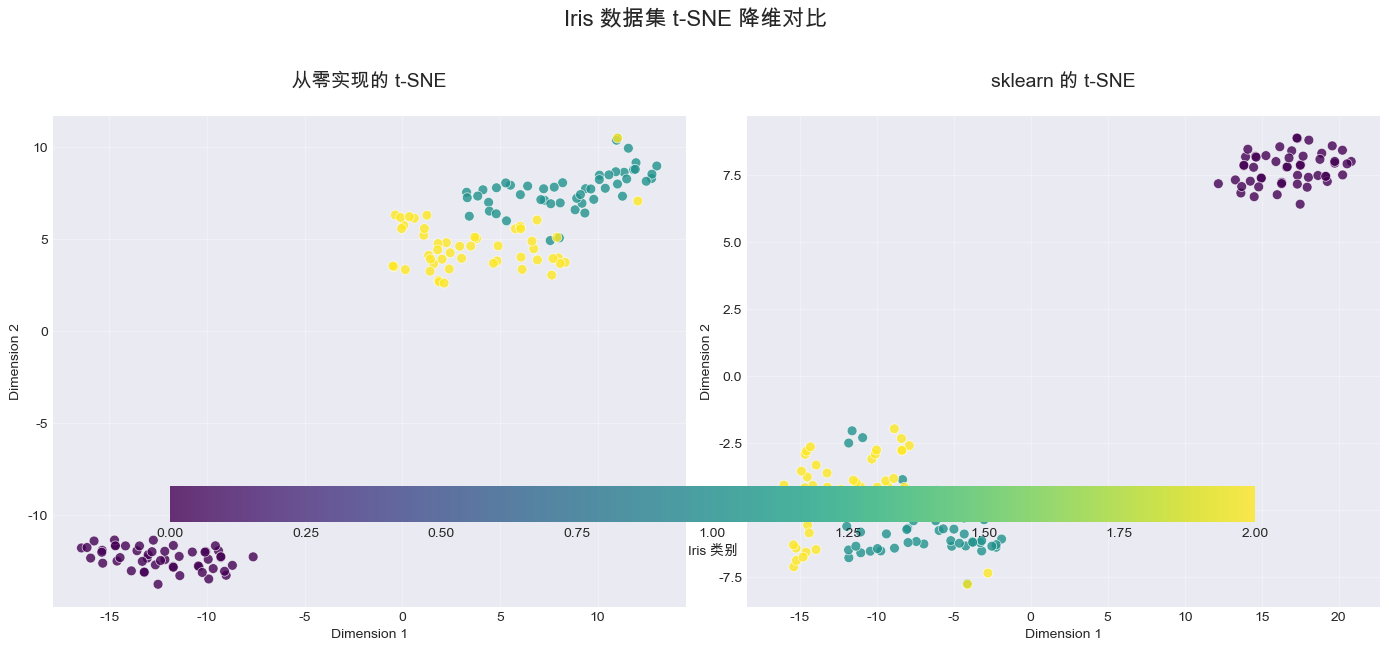


📊 量化对比 (Silhouette Score, 越高越好):
   从零实现: 0.5261
   sklearn:  0.5176

💡 观察:
   - 两种实现都能很好地分离 Iris 的三个类别
   - sklearn 版本经过高度优化，速度更快
   - 我们的教学版本帮助理解算法内部原理

✅ 通过从零实现，你已经深入理解了 t-SNE 的工作原理！


In [12]:
# ============================================================================
# 对比：从零实现 vs sklearn 实现
# ============================================================================

print("\n" + "=" * 60)
print("对比: 从零实现 vs sklearn 实现")
print("=" * 60)

# 使用 sklearn 的 t-SNE
from sklearn.manifold import TSNE

sklearn_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=500,
    random_state=42
)
Y_sklearn = sklearn_tsne.fit_transform(X_test_scaled)

# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 我们的实现
ax1 = axes[0]
scatter1 = ax1.scatter(Y_our[:, 0], Y_our[:, 1], c=y_test, cmap='viridis', 
                       s=50, alpha=0.8, edgecolors='white', linewidth=0.5)
ax1.set_title('从零实现的 t-SNE\n', fontsize=14, fontweight='bold')
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')
ax1.grid(True, alpha=0.3)

# sklearn 实现
ax2 = axes[1]
scatter2 = ax2.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=y_test, cmap='viridis',
                       s=50, alpha=0.8, edgecolors='white', linewidth=0.5)
ax2.set_title('sklearn 的 t-SNE\n', fontsize=14, fontweight='bold')
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
ax2.grid(True, alpha=0.3)

# 添加颜色条
plt.colorbar(scatter1, ax=axes, label='Iris 类别', orientation='horizontal', 
             pad=0.1, aspect=30)

plt.suptitle('Iris 数据集 t-SNE 降维对比', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 计算 Silhouette 分数进行量化对比
from sklearn.metrics import silhouette_score

sil_our = silhouette_score(Y_our, y_test)
sil_sklearn = silhouette_score(Y_sklearn, y_test)

print(f"\n📊 量化对比 (Silhouette Score, 越高越好):")
print(f"   从零实现: {sil_our:.4f}")
print(f"   sklearn:  {sil_sklearn:.4f}")

print("\n💡 观察:")
print("   - 两种实现都能很好地分离 Iris 的三个类别")
print("   - sklearn 版本经过高度优化，速度更快")
print("   - 我们的教学版本帮助理解算法内部原理")
print("\n✅ 通过从零实现，你已经深入理解了 t-SNE 的工作原理！")

## 5. t-SNE关键参数

### 5.1 perplexity（困惑度）

**含义**：可以理解为每个点的『有效邻居数量』

- **范围**：通常5-50
- **影响**：
  - 小值（5-10）：关注局部结构，可能产生碎片化簇
  - 大值（30-50）：关注全局结构，可能丢失细节
  - 推荐：30（默认值，适合大多数情况）

### 5.2 learning_rate（学习率）

- **范围**：10-1000
- **默认**：200
- **影响**：
  - 过小：收敛慢，可能陷入局部最优
  - 过大：不稳定，结果像随机噪声

### 5.3 n_iter（迭代次数）

- **推荐**：≥250（默认1000）
- **影响**：迭代次数不足会导致结果不稳定

### 5.4 early_exaggeration（早期夸大）

- **默认**：12
- **作用**：早期阶段放大簇间距离，帮助形成清晰的簇

---

## 6. t-SNE参数演示

数据形状: (500, 64)
类别数: 10

正在计算 perplexity=5...

正在计算 perplexity=15...

正在计算 perplexity=30...

正在计算 perplexity=50...


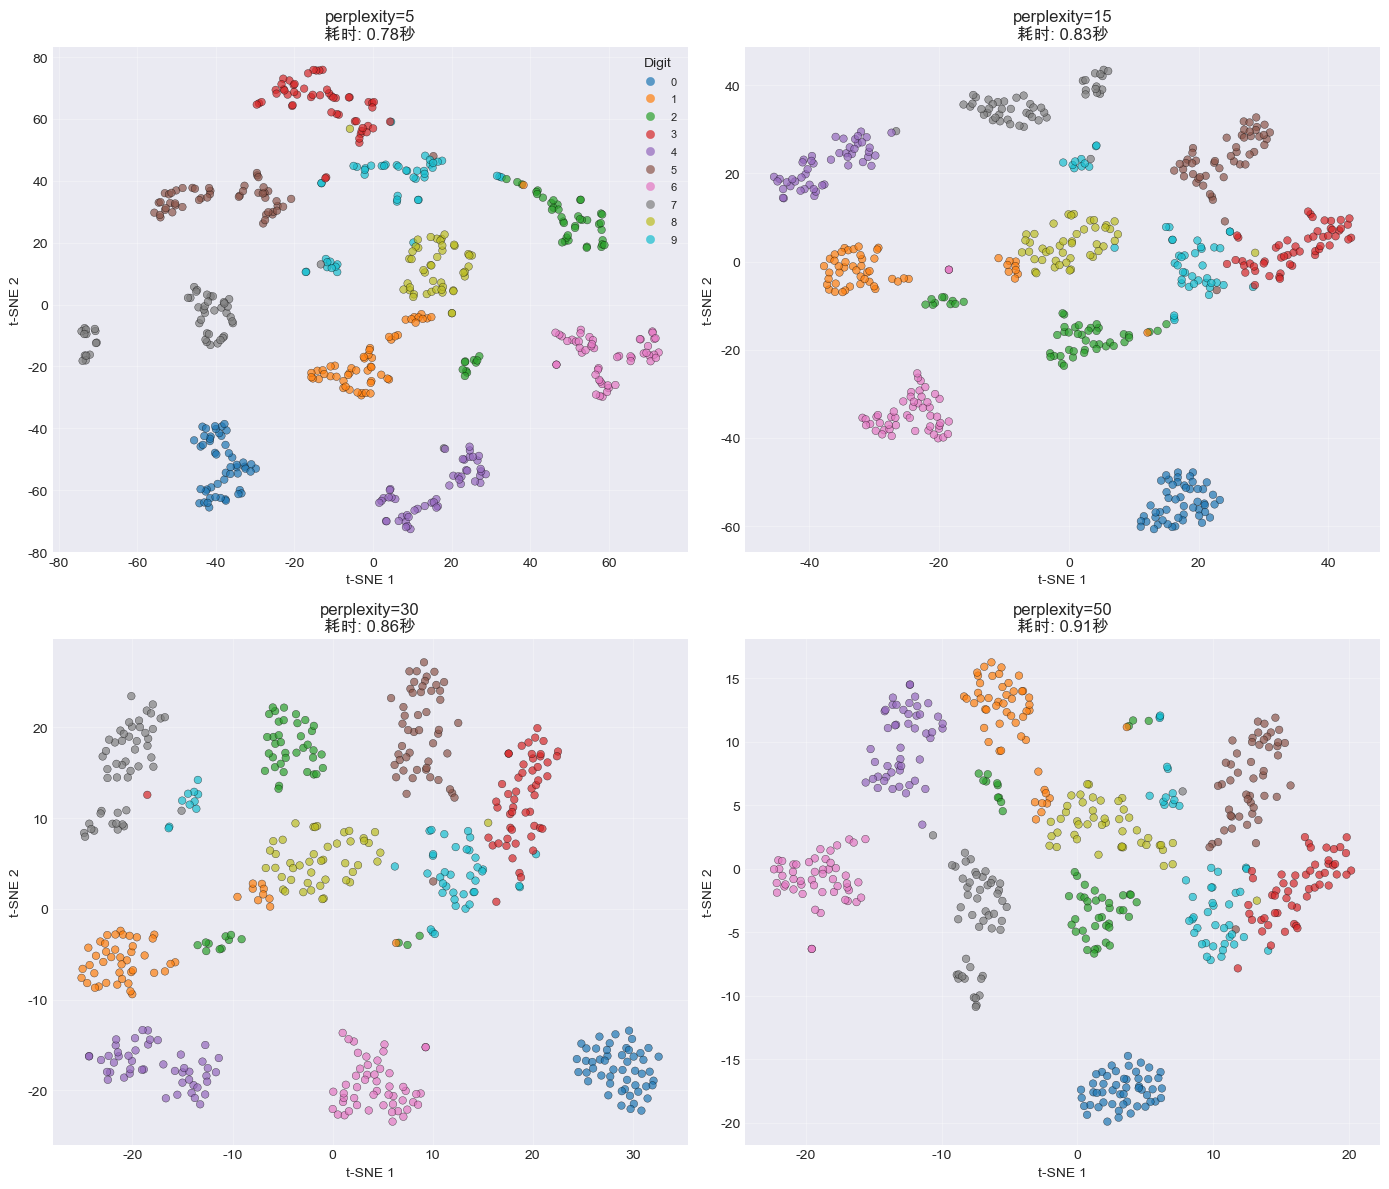


💡 观察不同perplexity的影响:
  - perplexity=5: 局部结构明显，但簇可能过于碎片化
  - perplexity=15: 较好的局部和全局平衡
  - perplexity=30: 默认值，通常效果最好
  - perplexity=50: 关注全局结构，但可能丢失细节

✅ 建议: 对于大多数数据，perplexity=30是个好起点


In [13]:
# 演示不同perplexity的影响
from sklearn.datasets import load_digits

# 加载digits数据集（小规模，方便演示）
digits = load_digits()
X_digits = digits.data[:500]  # 只取500个样本加速
y_digits = digits.target[:500]

print(f"数据形状: {X_digits.shape}")
print(f"类别数: {len(np.unique(y_digits))}")

# 标准化
scaler = StandardScaler()
X_digits_scaled = scaler.fit_transform(X_digits)

# 测试不同的perplexity值
perplexity_values = [5, 15, 30, 50]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, perp in enumerate(perplexity_values):
    print(f"\n正在计算 perplexity={perp}...")
    start_time = time.time()
    
    # 应用t-SNE
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42,
                n_iter=1000, learning_rate=200)
    X_tsne = tsne.fit_transform(X_digits_scaled)
    
    elapsed_time = time.time() - start_time
    
    # 可视化
    ax = axes[idx]
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                        c=y_digits, cmap='tab10', s=30, alpha=0.7,
                        edgecolors='black', linewidth=0.3)
    ax.set_title(f'perplexity={perp}\n耗时: {elapsed_time:.2f}秒',
                fontsize=12, fontweight='bold')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.grid(True, alpha=0.3)
    
    # 添加图例（仅第一个子图）
    if idx == 0:
        legend = ax.legend(*scatter.legend_elements(),
                          title="Digit", loc='best', fontsize=8)

plt.tight_layout()
plt.show()

print("\n💡 观察不同perplexity的影响:")
print("  - perplexity=5: 局部结构明显，但簇可能过于碎片化")
print("  - perplexity=15: 较好的局部和全局平衡")
print("  - perplexity=30: 默认值，通常效果最好")
print("  - perplexity=50: 关注全局结构，但可能丢失细节")
print("\n✅ 建议: 对于大多数数据，perplexity=30是个好起点")

## 7. t-SNE实战：MNIST数字完整可视化

In [14]:
# 加载完整的digits数据集
digits_full = load_digits()
X_digits_full = digits_full.data
y_digits_full = digits_full.target

print(f"完整数据形状: {X_digits_full.shape}")
print(f"样本数: {X_digits_full.shape[0]}")
print(f"特征数: {X_digits_full.shape[1]} (8x8像素)")

# 标准化
X_digits_full_scaled = StandardScaler().fit_transform(X_digits_full)

# 应用t-SNE
print("\n正在运行t-SNE（这可能需要几分钟）...")
start_time = time.time()
tsne_full = TSNE(n_components=2, perplexity=30, random_state=42,
                n_iter=1000, learning_rate=200, verbose=0)
X_tsne_full = tsne_full.fit_transform(X_digits_full_scaled)
elapsed_time = time.time() - start_time
print(f"✅ t-SNE完成！耗时: {elapsed_time:.2f}秒")

# 同时计算PCA用于对比
pca_full = PCA(n_components=2)
X_pca_full = pca_full.fit_transform(X_digits_full_scaled)

完整数据形状: (1797, 64)
样本数: 1797
特征数: 64 (8x8像素)

正在运行t-SNE（这可能需要几分钟）...
✅ t-SNE完成！耗时: 2.01秒


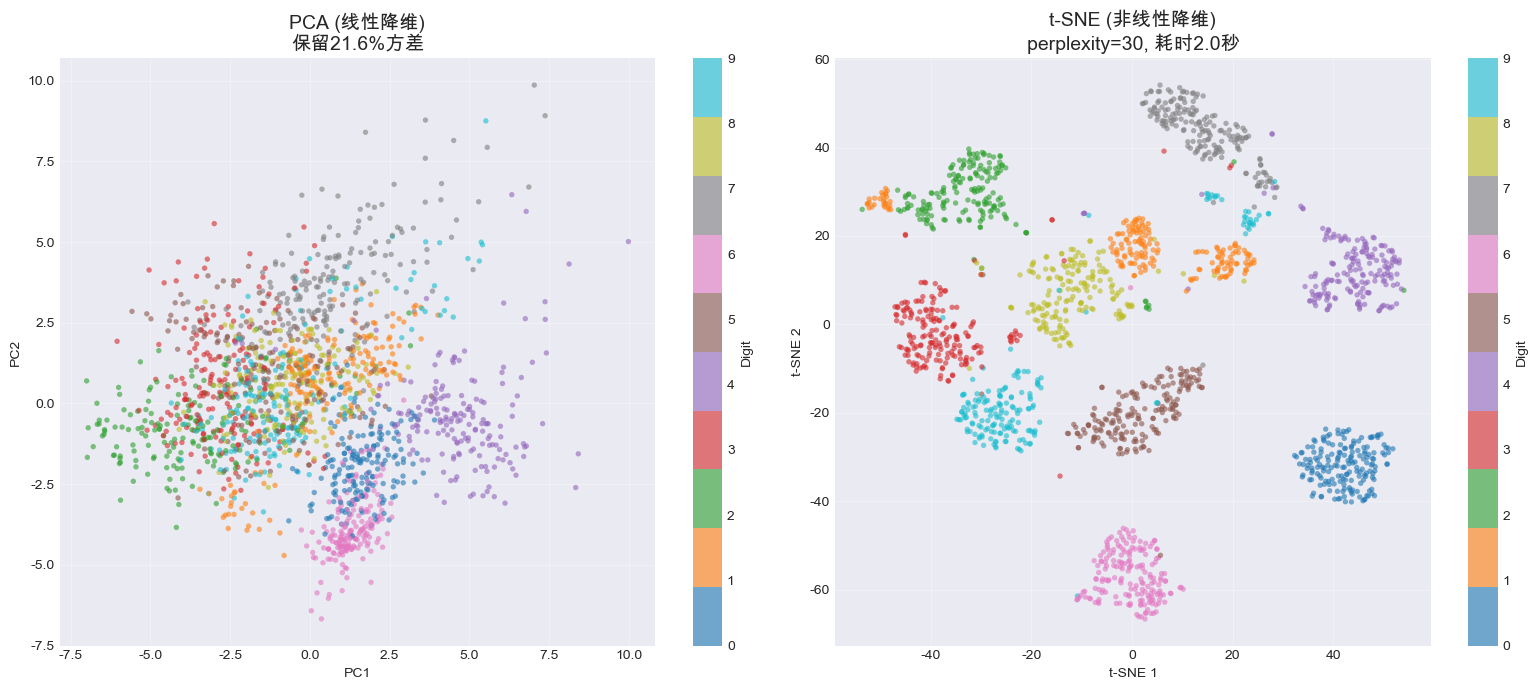


💡 PCA vs t-SNE对比:
  PCA:
    - 数字类别有一定分离，但重叠较多
    - 速度快，适合快速探索
    - 保持全局结构，但局部结构模糊

  t-SNE:
    - 相同数字形成清晰的簇
    - 类别边界更明显
    - 保持局部结构，但簇间距离无意义
    - 计算时间较长


In [15]:
# 可视化对比：PCA vs t-SNE
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA
ax1 = axes[0]
scatter1 = ax1.scatter(X_pca_full[:, 0], X_pca_full[:, 1],
                      c=y_digits_full, cmap='tab10', s=15, alpha=0.6,
                      edgecolors='none')
ax1.set_title(f'PCA (线性降维)\n'
             f'保留{pca_full.explained_variance_ratio_.sum():.1%}方差',
             fontsize=14, fontweight='bold')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, ticks=range(10), label='Digit')

# t-SNE
ax2 = axes[1]
scatter2 = ax2.scatter(X_tsne_full[:, 0], X_tsne_full[:, 1],
                      c=y_digits_full, cmap='tab10', s=15, alpha=0.6,
                      edgecolors='none')
ax2.set_title(f't-SNE (非线性降维)\n'
             f'perplexity=30, 耗时{elapsed_time:.1f}秒',
             fontsize=14, fontweight='bold')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, ticks=range(10), label='Digit')

plt.tight_layout()
plt.show()

print("\n💡 PCA vs t-SNE对比:")
print("  PCA:")
print("    - 数字类别有一定分离，但重叠较多")
print("    - 速度快，适合快速探索")
print("    - 保持全局结构，但局部结构模糊")
print("\n  t-SNE:")
print("    - 相同数字形成清晰的簇")
print("    - 类别边界更明显")
print("    - 保持局部结构，但簇间距离无意义")
print("    - 计算时间较长")

### t-SNE的重要注意事项 ⚠️

1. **簇间距离无意义**
   - ❌ 不能说『簇A和簇B很近，所以它们相似』
   - ✅ 只能说『同一个簇内的点相似』

2. **簇的大小无意义**
   - ❌ 不能说『簇A比簇B大，所以簇A样本更多』
   - ✅ 簇的大小受perplexity等参数影响

3. **不同运行结果不同**
   - t-SNE是随机算法，每次运行结果略有不同
   - 设置`random_state`可以保证可复现性

4. **不适合降维后建模**
   - ❌ 不要用t-SNE降维后的数据训练分类器
   - ✅ t-SNE主要用于可视化和探索

---

## 8. UMAP（均匀流形逼近与投影）

### 8.1 UMAP简介

**UMAP** (Uniform Manifold Approximation and Projection) 是一种较新的降维技术（2018年）

### 8.2 核心优势

相比t-SNE，UMAP有以下优势：

1. **速度更快**：O(n log n) vs t-SNE的O(n²)
2. **保持全局结构**：比t-SNE更好地保持数据的全局几何
3. **可扩展性**：适合大规模数据（10万+样本）
4. **适合降维后建模**：降维结果可以用于后续机器学习

### 8.3 数学基础

UMAP基于**黎曼几何**和**拓扑数据分析**：

1. **假设**：数据位于高维空间的低维流形上
2. **构建**：高维空间的模糊拓扑表示
3. **优化**：找到低维空间中的最佳模糊拓扑表示
4. **度量**：使用交叉熵优化（类似t-SNE的KL散度）

---

In [ ]:
# 检查UMAP是否可用
if not UMAP_AVAILABLE:
    print("⚠️ UMAP未安装，跳过UMAP相关实验")
    print("安装命令: pip install umap-learn")
    print("\n注意：本notebook的其他部分不受影响")
else:
    print("✅ UMAP已安装，开始实验")

## 9. UMAP关键参数

### 9.1 n_neighbors（邻居数）

**含义**：局部邻域的大小

- **范围**：2-100
- **默认**：15
- **影响**：
  - 小值（2-10）：关注局部结构，形成更多小簇
  - 大值（50-100）：关注全局结构，形成更大簇

### 9.2 min_dist（最小距离）

**含义**：低维空间中点之间的最小距离

- **范围**：0.0-0.99
- **默认**：0.1
- **影响**：
  - 小值（0.0）：点聚集更紧密，簇更清晰
  - 大值（0.5-0.9）：点分布更均匀，簇边界模糊

### 9.3 metric（距离度量）

- **常用**：'euclidean', 'cosine', 'manhattan'
- **默认**：'euclidean'
- **建议**：
  - 图像/数值数据 → 'euclidean'
  - 文本/词向量 → 'cosine'

---


正在计算 n_neighbors=5...

正在计算 n_neighbors=15...

正在计算 n_neighbors=50...

正在计算 n_neighbors=100...


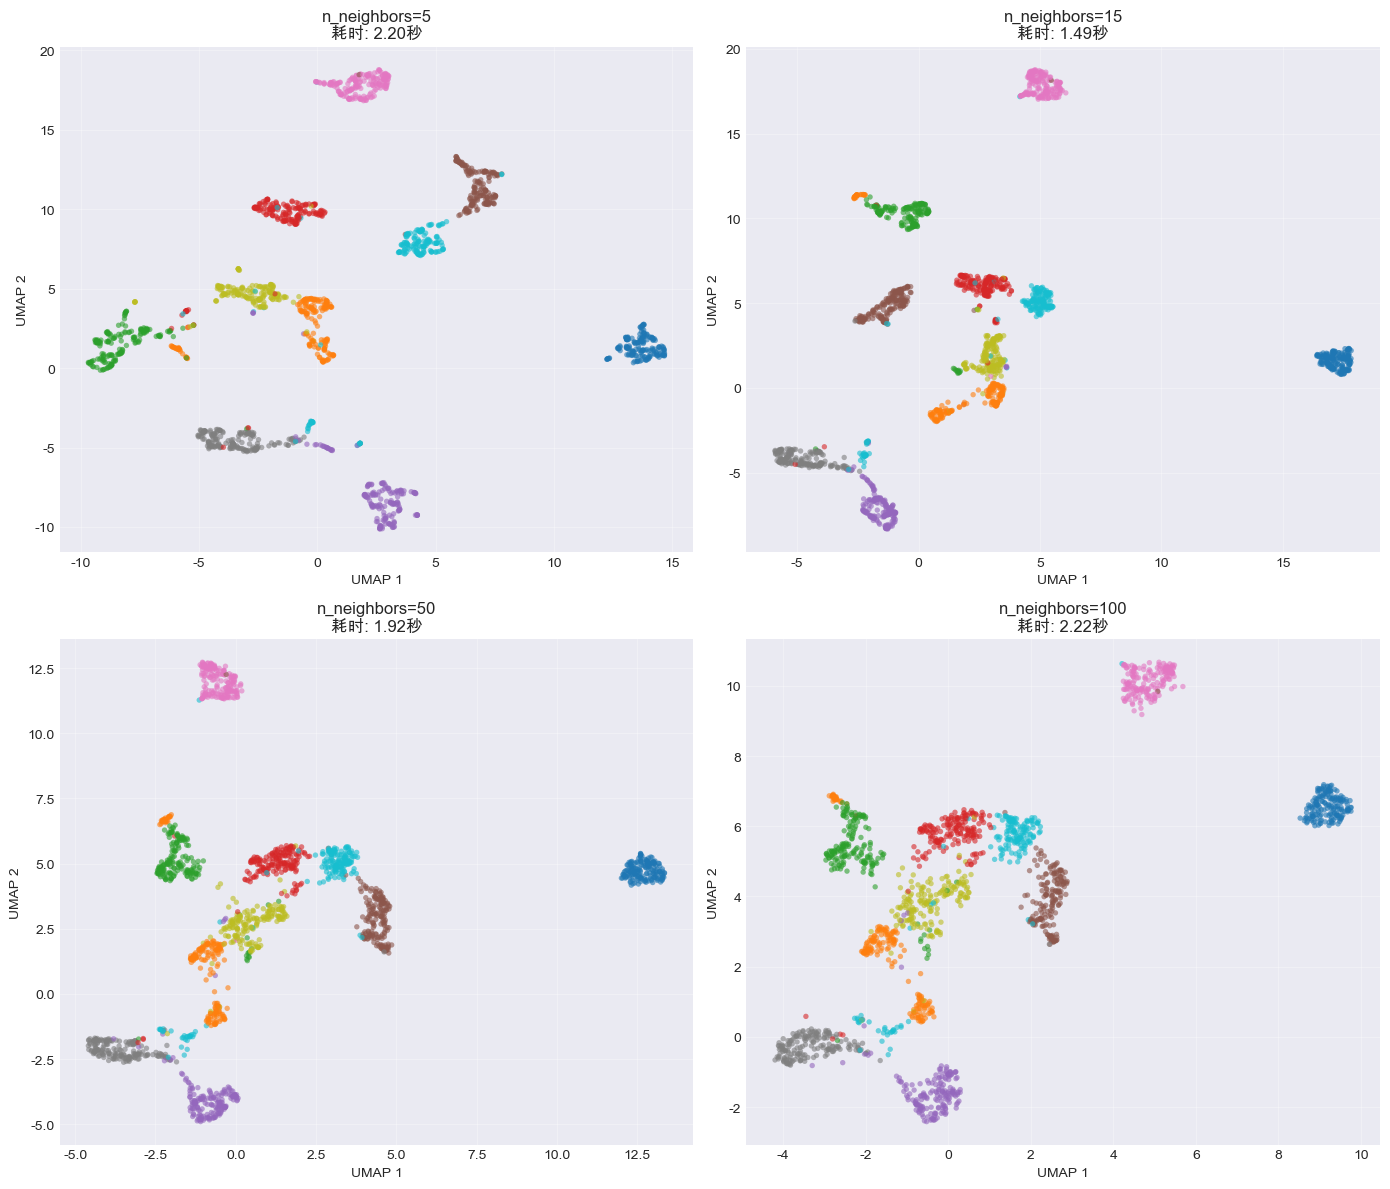


💡 观察不同n_neighbors的影响:
  - n_neighbors=5: 关注微观局部结构
  - n_neighbors=15: 默认值，平衡局部和全局
  - n_neighbors=50: 更关注全局结构
  - n_neighbors=100: 强调全局关系

⚡ UMAP比t-SNE快得多！


In [16]:
if UMAP_AVAILABLE:
    # 演示不同n_neighbors的影响
    n_neighbors_values = [5, 15, 50, 100]
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.ravel()
    
    for idx, n_neigh in enumerate(n_neighbors_values):
        print(f"\n正在计算 n_neighbors={n_neigh}...")
        start_time = time.time()
        
        # 应用UMAP
        reducer = umap.UMAP(n_neighbors=n_neigh, min_dist=0.1,
                           random_state=42, n_components=2)
        X_umap = reducer.fit_transform(X_digits_full_scaled)
        
        elapsed_time = time.time() - start_time
        
        # 可视化
        ax = axes[idx]
        scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1],
                            c=y_digits_full, cmap='tab10', s=15, alpha=0.6,
                            edgecolors='none')
        ax.set_title(f'n_neighbors={n_neigh}\n耗时: {elapsed_time:.2f}秒',
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 观察不同n_neighbors的影响:")
    print("  - n_neighbors=5: 关注微观局部结构")
    print("  - n_neighbors=15: 默认值，平衡局部和全局")
    print("  - n_neighbors=50: 更关注全局结构")
    print("  - n_neighbors=100: 强调全局关系")
    print("\n⚡ UMAP比t-SNE快得多！")
else:
    print("跳过UMAP参数演示（UMAP未安装）")

## 10. 三方对比：PCA vs t-SNE vs UMAP

In [17]:
# 完整对比三种方法
print("开始三方对比实验...\n")

# PCA
print("1. PCA...")
start = time.time()
pca_model = PCA(n_components=2)
X_pca = pca_model.fit_transform(X_digits_full_scaled)
time_pca = time.time() - start
sil_pca = silhouette_score(X_pca, y_digits_full)
print(f"   耗时: {time_pca:.3f}秒, Silhouette: {sil_pca:.3f}")

# t-SNE
print("\n2. t-SNE...")
start = time.time()
tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne_model.fit_transform(X_digits_full_scaled)
time_tsne = time.time() - start
sil_tsne = silhouette_score(X_tsne, y_digits_full)
print(f"   耗时: {time_tsne:.3f}秒, Silhouette: {sil_tsne:.3f}")

# UMAP
if UMAP_AVAILABLE:
    print("\n3. UMAP...")
    start = time.time()
    umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap = umap_model.fit_transform(X_digits_full_scaled)
    time_umap = time.time() - start
    sil_umap = silhouette_score(X_umap, y_digits_full)
    print(f"   耗时: {time_umap:.3f}秒, Silhouette: {sil_umap:.3f}")
else:
    X_umap = None
    time_umap = 0
    sil_umap = 0
    print("\n3. UMAP... 跳过（未安装）")

开始三方对比实验...

1. PCA...
   耗时: 0.072秒, Silhouette: 0.055

2. t-SNE...
   耗时: 1.920秒, Silhouette: 0.484

3. UMAP...
   耗时: 1.703秒, Silhouette: 0.540


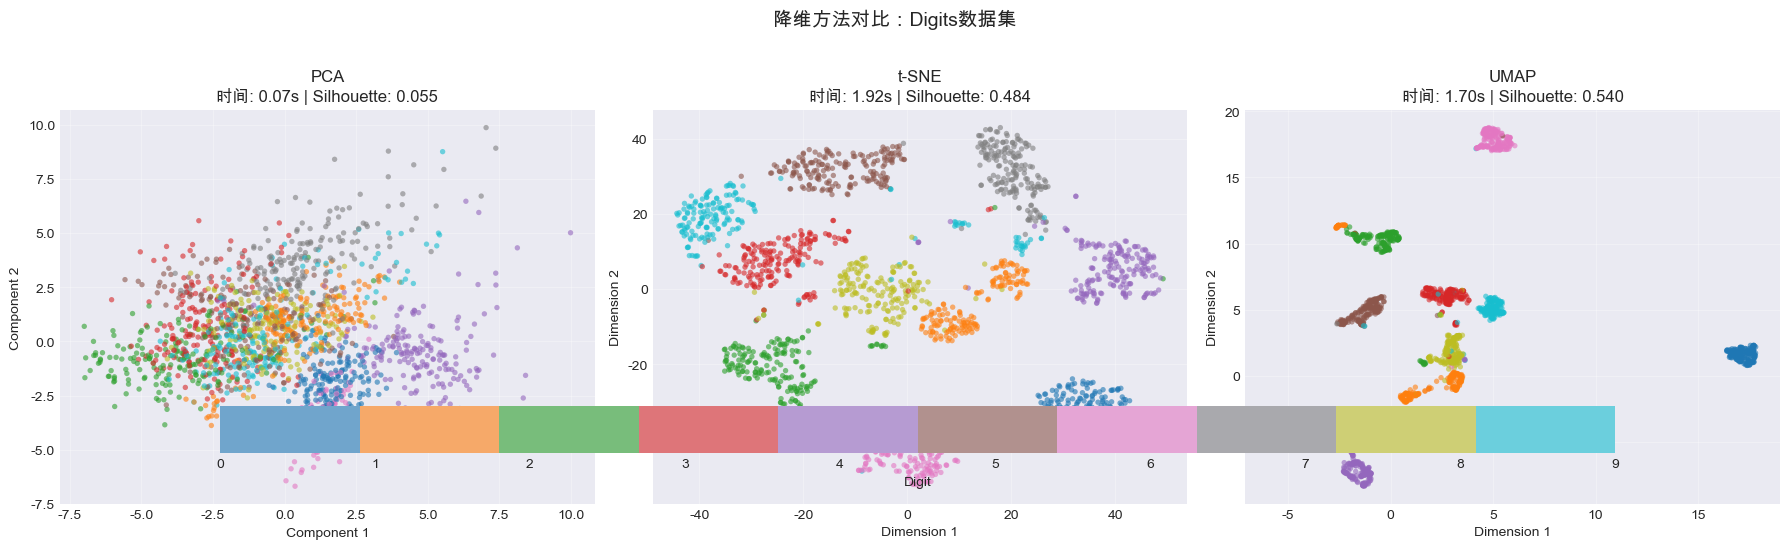


📊 性能对比:
   方法    时间(秒)  Silhouette分数  类型 适合大数据 适合建模
  PCA 0.072005      0.054741  线性     ✅    ✅
t-SNE 1.920004      0.484022 非线性     ❌    ❌
 UMAP 1.703284      0.540103 非线性     ✅    ✅

💡 总结:
  - PCA: 最快，但类别分离较差
  - t-SNE: 类别分离最好，但速度最慢
  - UMAP: 速度快，分离效果好，是实际应用的最佳选择


In [18]:
# 可视化三方对比
n_plots = 3 if UMAP_AVAILABLE else 2
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

if n_plots == 2:
    axes = [axes[0], axes[1]]

# PCA
ax = axes[0]
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_digits_full,
                    cmap='tab10', s=15, alpha=0.6, edgecolors='none')
ax.set_title(f'PCA\n时间: {time_pca:.2f}s | Silhouette: {sil_pca:.3f}',
            fontsize=12, fontweight='bold')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.grid(True, alpha=0.3)

# t-SNE
ax = axes[1]
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_digits_full,
          cmap='tab10', s=15, alpha=0.6, edgecolors='none')
ax.set_title(f't-SNE\n时间: {time_tsne:.2f}s | Silhouette: {sil_tsne:.3f}',
            fontsize=12, fontweight='bold')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.grid(True, alpha=0.3)

# UMAP
if UMAP_AVAILABLE:
    ax = axes[2]
    ax.scatter(X_umap[:, 0], X_umap[:, 1], c=y_digits_full,
              cmap='tab10', s=15, alpha=0.6, edgecolors='none')
    ax.set_title(f'UMAP\n时间: {time_umap:.2f}s | Silhouette: {sil_umap:.3f}',
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.grid(True, alpha=0.3)

# 添加图例
plt.colorbar(scatter, ax=axes, ticks=range(10), label='Digit',
            orientation='horizontal', pad=0.05, aspect=30)

plt.suptitle('降维方法对比：Digits数据集', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 性能对比表格
comparison_data = {
    '方法': ['PCA', 't-SNE'],
    '时间(秒)': [time_pca, time_tsne],
    'Silhouette分数': [sil_pca, sil_tsne],
    '类型': ['线性', '非线性'],
    '适合大数据': ['✅', '❌'],
    '适合建模': ['✅', '❌']
}

if UMAP_AVAILABLE:
    comparison_data['方法'].append('UMAP')
    comparison_data['时间(秒)'].append(time_umap)
    comparison_data['Silhouette分数'].append(sil_umap)
    comparison_data['类型'].append('非线性')
    comparison_data['适合大数据'].append('✅')
    comparison_data['适合建模'].append('✅')

comparison = pd.DataFrame(comparison_data)

print("\n📊 性能对比:")
print(comparison.to_string(index=False))

print("\n💡 总结:")
print("  - PCA: 最快，但类别分离较差")
print("  - t-SNE: 类别分离最好，但速度最慢")
if UMAP_AVAILABLE:
    print("  - UMAP: 速度快，分离效果好，是实际应用的最佳选择")

## 11. 最佳实践与建议

### 11.1 何时使用哪种方法？

#### 使用PCA ✅
- 需要快速探索数据
- 降维后要进行建模
- 需要可解释的主成分
- 数据基本是线性的

#### 使用t-SNE ✅
- 仅用于可视化
- 数据量不大（<10,000样本）
- 关注局部簇结构
- 对速度要求不高

#### 使用UMAP ✅
- 大规模数据（>10,000样本）
- 需要保持全局结构
- 降维后可能要建模
- 对速度有要求

### 11.2 数据预处理建议

1. **标准化**：总是标准化数据
```python
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
```

2. **PCA预降维**：对于超高维数据（>100维），先用PCA降到50维
```python
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_high_dim)
# 然后再用t-SNE或UMAP
```

3. **去除异常值**：异常值会严重影响降维结果

### 11.3 参数调优建议

#### t-SNE推荐起点
```python
TSNE(n_components=2,
     perplexity=30,      # 30是好起点
     learning_rate=200,  # 默认值
     n_iter=1000,        # 至少1000次
     random_state=42)    # 保证可复现
```

#### UMAP推荐起点
```python
umap.UMAP(n_neighbors=15,  # 15是好起点
          min_dist=0.1,     # 0.1是好起点
          metric='euclidean',
          random_state=42)
```

### 11.4 常见错误 🚫

1. **错误**：使用t-SNE降维后的数据训练分类器
   - ✅ 正确：只用于可视化

2. **错误**：解释簇间距离
   - ✅ 正确：只关注簇内结构

3. **错误**：只运行一次t-SNE就下结论
   - ✅ 正确：多次运行，观察稳定性

4. **错误**：不标准化数据
   - ✅ 正确：总是先标准化

---

## 12. 小结

### 🎯 本节要点

1. **非线性降维**：能够处理PCA无法处理的流形结构
2. **t-SNE**：
   - 保持局部结构，适合可视化
   - 关键参数：perplexity（困惑度）
   - 注意：簇间距离无意义，不适合降维后建模
3. **UMAP**：
   - 速度快，保持全局+局部结构
   - 关键参数：n_neighbors、min_dist
   - 适合大规模数据和降维后建模
4. **选择建议**：
   - 快速探索 → PCA
   - 可视化（小数据）→ t-SNE
   - 可视化（大数据）→ UMAP
   - 降维后建模 → PCA或UMAP

### 三种方法特点

| | PCA | t-SNE | UMAP |
|---|---|---|---|
| **速度** | ⚡⚡⚡ | ⚡ | ⚡⚡ |
| **局部结构** | ⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐ |
| **全局结构** | ⭐⭐⭐ | ⭐ | ⭐⭐ |
| **可解释性** | ⭐⭐⭐ | ⭐ | ⭐ |
| **确定性** | ⭐⭐⭐ | ⭐ | ⭐ |
| **大数据** | ⭐⭐⭐ | ⭐ | ⭐⭐⭐ |

### ✅ 检查清单

- [ ] 理解PCA的局限性和非线性降维的必要性
- [ ] 掌握t-SNE的原理和关键参数
- [ ] 理解UMAP的优势
- [ ] 能够选择合适的降维方法
- [ ] 知道如何调优参数
- [ ] 了解常见错误和最佳实践

### 🚀 下一步

继续学习 `06_anomaly_detection.ipynb` - 异常检测算法

---

**💪 做得好！你已经掌握了非线性降维技术！**